# Preprocessing data for pipeline Siamese network architecture  + L1 distance

After this preprocessing step, result in `preprocessed_data(for_Siamese)` folder, we use these data to train a the Siamese network architecture with L1 distance, see in `Siamese_Network.ipynb` notebook.

In [1]:
import cv2 # OpenCV
import os  # For file operations
import random
import numpy as np
from matplotlib import pyplot as plt # For plotting graphs
from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed
from PIL import Image
import tensorflow as tf

## Objective

- Build funtion to preprocess image
- Detect faces in images and crop them to only contain the face, store in a compressed format



## 1. Preprocess Image function


We define a function to preprocess the images. The function accepts the inpput as the image path (string format) or the frame (numpy array format). 

Why we need two of these:

- When we want to process the images to create the dataset, provide image path to load images from the disk

- When we want to verify the image directly from the camera, provide the frame object by OpenCV to the function. (we do this in Part 7)


Note that to use the Gaussian Smoothing filter, I defined a function `gaussian_blur` that accepts the image and the kernel size as the input.

In [2]:
def gaussian_blur(image, kernel_size=(3,3), sigma=0.1):
    """
    Apply Gaussian blur to an image using TensorFlow with auto-determined sigma.
    
    Args:
    - image: Input image tensor
    - kernel_size: Size of the Gaussian kernel (height, width)
    
    Returns:
    - Smoothed image
    """
    
    # Ensure the image is a tensor
    if not isinstance(image, tf.Tensor):
        image = tf.convert_to_tensor(image)
    
    # Ensure 4D tensor [batch, height, width, channels]
    if len(image.shape) == 3:
        image = image[tf.newaxis, :, :, :]
    
    # Create Gaussian kernel for each channel
    def create_gaussian_kernel(size, sigma=1.0):
        """Generate a 2D Gaussian kernel"""
        size = int(size)
        x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
        g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
        return g / g.sum()
    
    # Create kernel
    kernel_height, kernel_width = kernel_size
    kernel = create_gaussian_kernel(kernel_height, sigma)
    
    # Expand kernel for all channels
    num_channels = image.shape[-1]
    kernel_4d = np.expand_dims(kernel, axis=-1)
    kernel_4d = np.repeat(kernel_4d, num_channels, axis=-1)
    kernel_4d = np.expand_dims(kernel_4d, axis=-1)
    
    # Convert kernel to float32 tensor
    kernel_tensor = tf.convert_to_tensor(kernel_4d, dtype=tf.float32)
    
    # Apply convolution
    blurred = tf.nn.depthwise_conv2d(
        input=image, 
        filter=kernel_tensor, 
        strides=[1, 1, 1, 1], 
        padding='SAME'
    )
    
    # Remove batch dimension if it was added
    return blurred[0] if blurred.shape[0] == 1 else blurred

In [3]:
def preprocess(input_data):
    """
    Preprocess image data from various input formats into a standardized tensor.
    
    Args:
    input_data: Can be a file path (str), bytes tensor, numpy array, or PIL Image
    
    Returns:
    A preprocessed tensor of shape (100, 100, 3) with values in [0,1]
    """
    try:
        # Handle PIL Image input
        if isinstance(input_data, Image.Image):
            input_data = np.array(input_data)
        
        # Image decoding and initial processing
        if isinstance(input_data, (str, bytes)) or (isinstance(input_data, tf.Tensor) and input_data.dtype == tf.string):
            # Convert tensor to string if needed
            if isinstance(input_data, tf.Tensor):
                input_data = input_data.numpy()
            if isinstance(input_data, bytes):
                input_data = input_data.decode('utf-8')
            
            # Read and decode the image
            byte_image = tf.io.read_file(input_data)
            image = tf.image.decode_jpeg(byte_image, channels=3)
        else:
            # Handle numpy array or TensorFlow tensor input
            image = tf.convert_to_tensor(input_data)
        
        # Convert to float32
        image = tf.cast(image, tf.float32)
        
        # Ensure shape is correct
        if len(image.shape) != 3:
            raise ValueError(f"Expected image with 3 dimensions, got shape {image.shape}")
        
        # Resize the image
        image = tf.image.resize(image, (100, 100))
        
        # Smooth the image
        image = gaussian_blur(image, kernel_size=(3,3), sigma=0.1)
        
        # Normalize the image
        # WIth deep learing, it is ensential to normalize, so   can improve model 
        # performance by ensuring that input data is within a smaller, consistent range, which can help with stability during training.
        image = image / 255.0  # Normalize to [0,1]

        '''
        However, scaling might make the image look lower quality because of the smaller numerical range (0-1), even though 
        this does not actually affect its visual structure when used in a deep learning model. This step is not 
        meant for direct visualization, but rather for preparing data for model input.

        If you are trying to visually inspect the image to verify it after scaling, you can:
        '''
        
        return image
    
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        print(f"Input type: {type(input_data)}")
        if isinstance(input_data, (str, bytes)):
            print(f"Input path: {input_data}")
        raise
# Note that our preprocess function return a Tensorflow tensor, not a numpy array, so when need  to  perform image 
# with OpenCV, we need to convert it to numpy array

# Wrap the preprocess function in a tf.py_function to deal with Frame objects in Opencv
def preprocess_wrapper(input_data):
    """Wrapper function to use with tf.py_function if needed"""
    return tf.py_function(preprocess, [input_data], tf.float32)

The correct dimension to resize will base on the model we use. For example:

- VGGFace: 224x224
- Facenet: 160x160
- ....

In this case, we use the Siamese model, the input size is 105x105, but we resize the image to 100x100, still work well.

Test the `prepreprocess` function with an example image:

testing with image: ./data\Alistair_MacDonald\Alistair_MacDonald_0001.jpg
Image  size before preprocessing: (250, 250, 3)


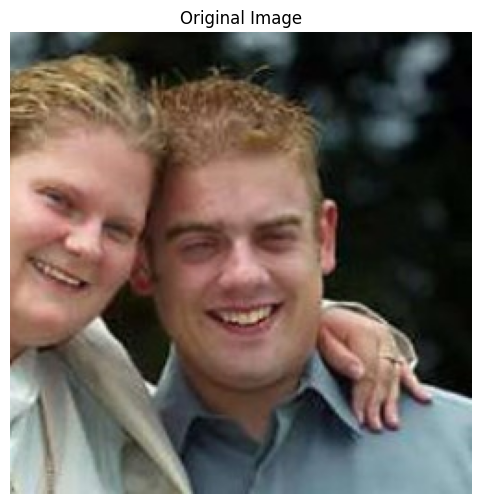

Image size after preprocessing: (100, 100, 3)


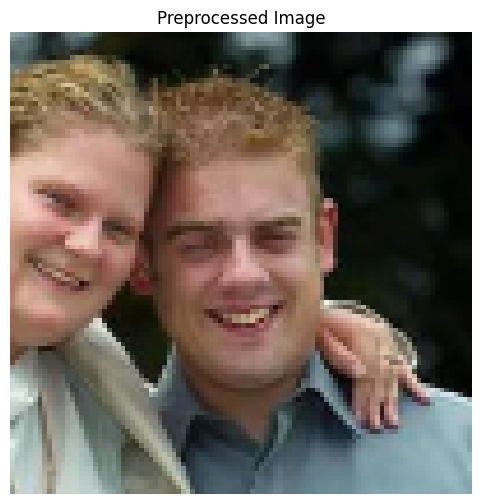

In [4]:
# Testing with an image inside the first subfolder inside ./data
# Path to an example image in the first subfolder
example_image_path = os.path.join('./data', os.listdir('./data')[0], os.listdir(os.path.join('./data', os.listdir('./data')[0]))[0])

print("testing with image:", example_image_path)

# Image before preprocessing
print("Image  size before preprocessing:", cv2.imread(example_image_path).shape)
plt.figure(figsize=(6,6))
# Display using RGB channel
plt.imshow(cv2.cvtColor(cv2.imread(example_image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')
plt.show()


# Image after preprocessing
print("Image size after preprocessing:", preprocess(example_image_path).shape)
plt.figure(figsize=(6,6))
# Display using RGB channel, resclae to [0,255], since the image after preprocessing is in [0,1], not for visualization
plt.imshow(tf.clip_by_value(preprocess(example_image_path) * 255, 0, 255).numpy().astype(np.uint8))

plt.title("Preprocessed Image")
plt.axis('off')
plt.show()



The image may look lower resolution, since we have resized it to 100x100. It gives lower resolution but reduce the computation cost and memory usage for the model.

## 2. Create Data Folder, detect faces and crop them, store in compressed format

In [5]:
# Create preprocessed_data(for Siamese) folder
os.makedirs('preprocessed_data(for_Siamese)', exist_ok=True)

# Inside that folder, create face_detect folder and face_embeddings folder
os.makedirs(os.path.join('preprocessed_data(for_Siamese)', 'face_detect'), exist_ok=True)

# since Siamese network base on feedback distance to update the extract features phase, we 
# can not have 'face_embeddings' folder at scratch

In [6]:
### Now, from the `data` folder, extract end align the faces (crop image to keep only face) 
# and save them in the `face_detect` folder ###


# Detect and extract faces from an image using MTCNN
# Parameters:
# - image_path: path to the image file
# - detector: MTCNN detector object
# - required_size: the size of the extracted face images (default is (160, 160))
def detect_and_extract_faces(image_path, detector, required_size=(160, 160)):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    detections = detector.detect_faces(image_np)

    if detections:
        detection = detections[0]
        x, y, width, height = detection['box']
        face = image_np[y:y+height, x:x+width]
        face_image = Image.fromarray(face).resize(required_size)
        return face_image
    else:
        # No face detected
        return None

# Process a single subfolder (since the data folder contains subfolders for each person, use this function to process each subfolder)
# Parameters:
# - subfolder: the subfolder name in data folder we want to process
# - face_only_dataset_dir: the directory to save the extracted faces. This is the subfolder with person's name inside the face_detect folder

# - detector: MTCNN detector object
def process_subfolder(subfolder, face_only_dataset_dir, detector):
    subfolder_path = os.path.join('./data', subfolder) #Acessing the subfolder in ./data to collect names of people
    new_faces_folder = os.path.join(face_only_dataset_dir, os.path.basename(subfolder)) # with each name, create a new folder in face_detect folder
    
    # Create the new_faces_folder if it does not exist
    os.makedirs(new_faces_folder, exist_ok=True)
    
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.jpg')] # For all images inside a person folder in the subfolder 
    faces = []
    
    i = 0 # Counter for the number of images in each subfolder
    for image_file in image_files:
       
        image_path = os.path.join(subfolder_path, image_file)
        face = detect_and_extract_faces(image_path, detector) # In this dataset, each of the image has only one face. 
        # If you want to apply with some dataset that has multiple faces in one image, use a loop here

        if face is None:
            print(f"No face detected in {image_file}")
            continue  # Skip to the next image

        #  After extracting the face, preprocess the face image
        face_array = np.array(face) if not isinstance(face, np.ndarray) else face
        preprocessed_face = preprocess(face_array)

        # Save the face image
        face_image = Image.fromarray((preprocessed_face.numpy() * 255).astype(np.uint8))
        face_image_path = os.path.join(new_faces_folder, f'{os.path.splitext(image_file)[0]}_face_{i+1}.jpg')
        face_image.save(face_image_path)
        faces.append(face_image)

        i += 1

        
    # Also, save all faces inside the subfolder to a single .npz file
    # Ensure all faces have the same shape before saving to .npz
    if faces:
        # Convert Image objects to numpy arrays
        faces = [np.array(face) if isinstance(face, Image.Image) else face for face in faces]
        
        face_shape = faces[0].shape
        faces = [face for face in faces if face.shape == face_shape]
        faces = np.array(faces)
        print("Saving to faces.npz in", new_faces_folder)
        savez_compressed(os.path.join(new_faces_folder, 'faces.npz'), faces)
    else:
        print("No faces found in", subfolder)


`faces.npz` is just simply a compressed file that contains all list of numpy arrays, where each numpy array is a face image. 

In [7]:
# Main function to process all subfolders

detector = MTCNN()

# Except the README file, process all subfolders

for subfolder in os.listdir('./data'):
    if subfolder == 'README.md':
        continue
    print("Processing face detection for:", subfolder)
    process_subfolder(subfolder, './preprocessed_data(for_Siamese)/face_detect', detector)

Processing face detection for: Alistair_MacDonald
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect\Alistair_MacDonald
Processing face detection for: Andrew_Wetzler
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect\Andrew_Wetzler
Processing face detection for: Bruce_Gebhardt
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect\Bruce_Gebhardt
Processing face detection for: Charles_Schumer
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect\Charles_Schumer
Processing face detection for: Connie_Freydell
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect\Connie_Freydell
Processing face detection for: David_Duval
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect\David_Duval
Processing face detection for: Gianna_Angelopoulos-Daskalaki
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect\Gianna_Angelopoulos-Daskalaki
Processing face detection for: Hank_Azaria
Saving to faces.np

First subfolder: Alistair_MacDonald
Keys in the .npz file: ['arr_0']
Shape of faces array: (6, 100, 100, 3)
Shape of the first face: (100, 100, 3)


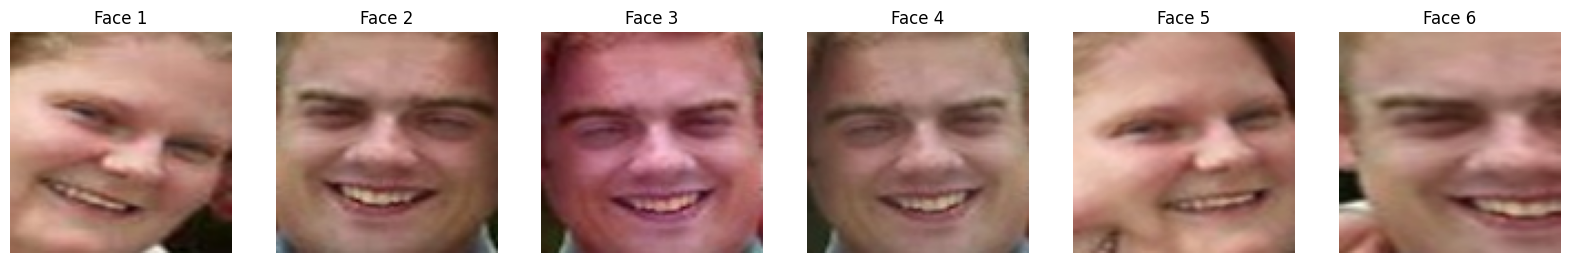

In [9]:
# Testing: load a faces.npz file in the first subfolder and display the faces

# Get the path to the first subfolder, excluding .gitkeep
subfolders = [f for f in os.listdir('./preprocessed_data(for_Siamese)/face_detect') if f != '.gitkeep']
first_subfolder = subfolders[0] if subfolders else None

if (first_subfolder):
    print("First subfolder:", first_subfolder)
    # Load the .npz file
    npz_file_path = os.path.join('./preprocessed_data(for_Siamese)/face_detect', first_subfolder, 'faces.npz')
    test = np.load(npz_file_path)

    # Print the keys in the .npz file
    print("Keys in the .npz file:", test.files)

    # Extract the faces array
    faces = test['arr_0']

    # Print the shape of the faces array
    print("Shape of faces array:", faces.shape)

    # Print the shape of the first face
    face_shape = faces[0].shape
    print("Shape of the first face:", face_shape)

    # Plot the faces
    plt.figure(figsize=(20, 5))
    for i, face in enumerate(faces):
        plt.subplot(1, len(faces), i+1)
        plt.axis('off')
        plt.title(f"Face {i+1}")
        plt.imshow(face)
    plt.show()